In [202]:
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import time
from utils import load_data, split_data, shuffle, weight_initialization
from metrics import compute_accuracy
from torchsummary import summary

In [2]:
train_data, test_data = load_data()
train_loader, valid_loader, test_loader = split_data(train_data, test_data)

In [398]:
def trial(net, train_loader, test_loader, n_epochs=25, n_trials=20, alpha=1, alpha_decay=1, verbose=True):
    all_losses = torch.zeros((n_trials, n_epochs))
    tr_accuracies = torch.zeros(n_trials)
    te_accuracies = torch.zeros(n_trials)
    for i in range(n_trials):
        # Shuffle data
        train_loader, valid_loader, test_loader = split_data(train_data, test_data)
        
        # Reset weights
        net.train()
        net.apply(weight_initialization)
        
        # Train
        start = time.time()
        train_loss = train(net, train_loader, alpha=alpha, alpha_decay=alpha_decay, verbose=False)
        print('Trial %d/%d... Training time: %.2f s' % (i+1, n_trials, time.time()-start))
        
        # Collect data
        all_losses[i] = train_loss
        
        net.eval()
        with torch.no_grad():
            tr_accuracies[i] = compute_accuracy(net, train_loader)
            te_accuracies[i] = compute_accuracy(net, test_loader)
        
        if verbose:
            print('Loss: %.3f, Train acc: %.3f, Test acc: %.3f' % 
                  (train_loss[-1], tr_accuracies[i], te_accuracies[i]))
    
    return all_losses, tr_accuracies, te_accuracies

In [447]:
def train(net, train_loader, eta=1e-3, decay=1e-5, n_epochs=25, alpha=1, alpha_decay=1, verbose=True):
    aux_crit = nn.CrossEntropyLoss()
    binary_crit = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=eta, weight_decay=decay)
    #optimizer = optim.RMSprop(net.parameters(), lr=eta, weight_decay=decay)
    #optimizer = optim.SGD(net.parameters(), lr=eta, weight_decay=decay, momentum=0.9, nesterov=True)
    #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

    tr_losses, val_losses = torch.zeros(n_epochs), torch.zeros(n_epochs)
    
    for e in range(n_epochs):
        tr_loss, val_loss, aux_loss = 0, 0, 0
        net.train()
        
        for (trainX, trainY, trainC) in train_loader:
            out, aux = net(trainX)
            
            aux1, aux2 = aux.unbind(1)
            c1, c2 = trainC.unbind(1)
            
            aux_loss = aux_crit(aux1, c1) + aux_crit(aux2, c2)

            binary_loss = binary_crit(out, trainY.float())
            
            total_loss = binary_loss + alpha*aux_loss
            
            tr_loss += total_loss.item()
           
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            for (valX, valY, trainC) in valid_loader:
                out, _ = net(valX)
                loss = binary_crit(out, valY.float())
                val_loss += loss.item()
        
        tr_losses[e] = tr_loss
        val_losses[e] = val_loss
                
        #scheduler.step(val_loss)
        alpha *= alpha_decay
        
        if verbose:
            print('Epoch %d/%d, Train loss: %.3f, Val loss: %.3f, Aux loss: %.3f' % 
                  (e+1, n_epochs, tr_loss, val_loss, aux_loss))
    
    return tr_losses

In [514]:
class Net(nn.Module):
    def __init__(self, hidden=128, verbose=True):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(14*14, hidden)
        self.fc2 = nn.Linear(hidden, 10)
        self.fc3 = nn.Linear(20, 10)
        self.fc4 = nn.Linear(10, 1)
       
        self.drop = nn.Dropout(0.2)

        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.sigmoid = nn.Sigmoid()
        
        if verbose:
            print(f'Parameters: {self.count_params()}')

    def count_params(self):
        return sum(p.numel() for p in self.parameters())
    
    def forward(self, x):   
        x = self.relu(self.fc1(x.flatten(start_dim=2)))
        #x = self.drop(x)
        x = self.relu(self.fc2(x))
        #x = self.drop(x)
        
        aux = x

        x = self.relu(self.fc3(x.flatten(start_dim=1)))
        #x = self.drop(x)
        x = self.sigmoid(self.fc4(x))
        return x.squeeze(), aux

In [515]:
class CNN(nn.Module):
    def __init__(self, verbose=True):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        
        self.conv3 = nn.Conv2d(64, 2, kernel_size=1)
        self.fc1 = nn.Linear(16, 10)
        
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

        self.drop = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(2,2)
        
        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.sigmoid = nn.Sigmoid()
        
        if verbose:
            print(f'Parameters: {self.count_params()}')

    def count_params(self):
        return sum(p.numel() for p in self.parameters())
    
    def forward(self, x):   
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        
        aux = self.relu(self.conv3(x))
        aux = self.fc1(aux.flatten(start_dim=2))
        
        x = self.pool(x)
        x = self.drop(self.relu(self.fc2(x.flatten(start_dim=1))))
        x = self.sigmoid(self.fc3(x))
        return x.squeeze(), aux

In [516]:
tt = None
for i, (img, lab, clas) in enumerate(train_loader):
    if i == 0:
        tt = img
cnn = CNN(verbose=False)

In [517]:
net = Net()
summary(net, (2, 14, 14))

Parameters: 26727
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 2, 128]          25,216
              ReLU-2               [-1, 2, 128]               0
            Linear-3                [-1, 2, 10]           1,290
              ReLU-4                [-1, 2, 10]               0
            Linear-5                   [-1, 10]             210
              ReLU-6                   [-1, 10]               0
            Linear-7                    [-1, 1]              11
           Sigmoid-8                    [-1, 1]               0
Total params: 26,727
Trainable params: 26,727
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.10
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


In [436]:
start = time.time()
net = Net(verbose=False)
tr_losses = train(net, train_loader, alpha=1, alpha_decay=.99, n_epochs=25)
print(time.time() - start)

Epoch 1/25, Train loss: 78.253, Val loss: 2.783, Aux loss: 3.645
Epoch 2/25, Train loss: 60.841, Val loss: 2.738, Aux loss: 2.767
Epoch 3/25, Train loss: 49.049, Val loss: 2.670, Aux loss: 2.002
Epoch 4/25, Train loss: 44.561, Val loss: 2.583, Aux loss: 2.211
Epoch 5/25, Train loss: 41.374, Val loss: 2.410, Aux loss: 1.904
Epoch 6/25, Train loss: 39.542, Val loss: 2.402, Aux loss: 2.080
Epoch 7/25, Train loss: 37.301, Val loss: 2.305, Aux loss: 1.874
Epoch 8/25, Train loss: 35.385, Val loss: 2.222, Aux loss: 1.858
Epoch 9/25, Train loss: 33.182, Val loss: 2.083, Aux loss: 1.584
Epoch 10/25, Train loss: 33.296, Val loss: 2.040, Aux loss: 1.797
Epoch 11/25, Train loss: 30.788, Val loss: 1.853, Aux loss: 1.702
Epoch 12/25, Train loss: 29.505, Val loss: 1.875, Aux loss: 1.545
Epoch 13/25, Train loss: 29.805, Val loss: 1.828, Aux loss: 1.692
Epoch 14/25, Train loss: 27.893, Val loss: 1.835, Aux loss: 1.272
Epoch 15/25, Train loss: 27.921, Val loss: 1.751, Aux loss: 1.590
Epoch 16/25, Train 

In [448]:
start = time.time()
net=CNN(verbose=False)
tr_losses = train(net, train_loader, alpha=0, alpha_decay=.99, eta=1e-3, decay=1e-5)
print(time.time() - start)

Epoch 1/25, Train loss: 10.870, Val loss: 2.736, Aux loss: 4.617
Epoch 2/25, Train loss: 10.130, Val loss: 2.418, Aux loss: 4.620
Epoch 3/25, Train loss: 8.936, Val loss: 2.205, Aux loss: 4.592
Epoch 4/25, Train loss: 7.899, Val loss: 2.045, Aux loss: 4.595
Epoch 5/25, Train loss: 7.131, Val loss: 1.839, Aux loss: 4.610
Epoch 6/25, Train loss: 6.248, Val loss: 1.908, Aux loss: 4.605
Epoch 7/25, Train loss: 5.639, Val loss: 1.821, Aux loss: 4.605
Epoch 8/25, Train loss: 5.108, Val loss: 1.587, Aux loss: 4.596
Epoch 9/25, Train loss: 4.428, Val loss: 1.683, Aux loss: 4.612
Epoch 10/25, Train loss: 3.264, Val loss: 1.708, Aux loss: 4.602
Epoch 11/25, Train loss: 2.886, Val loss: 1.906, Aux loss: 4.602
Epoch 12/25, Train loss: 2.251, Val loss: 1.825, Aux loss: 4.603
Epoch 13/25, Train loss: 1.639, Val loss: 1.959, Aux loss: 4.601
Epoch 14/25, Train loss: 1.273, Val loss: 1.843, Aux loss: 4.606
Epoch 15/25, Train loss: 0.899, Val loss: 2.019, Aux loss: 4.605
Epoch 16/25, Train loss: 0.602, 

In [491]:
compute_accuracy(net, test_loader)

0.901

In [526]:
all_losses, tr_accuracies, te_accuracies = trial(Net(64, verbose=False), train_loader, test_loader, 
                                                 n_trials=30, alpha=0, alpha_decay=1)

Trial 1/30... Training time: 3.60 s
Loss: 1.062, Train acc: 0.993, Test acc: 0.803
Trial 2/30... Training time: 3.93 s
Loss: 0.708, Train acc: 0.998, Test acc: 0.816
Trial 3/30... Training time: 3.51 s
Loss: 1.172, Train acc: 0.989, Test acc: 0.819
Trial 4/30... Training time: 3.48 s
Loss: 0.773, Train acc: 0.996, Test acc: 0.812
Trial 5/30... Training time: 3.52 s
Loss: 1.259, Train acc: 0.989, Test acc: 0.813
Trial 6/30... Training time: 3.60 s
Loss: 1.311, Train acc: 0.988, Test acc: 0.812
Trial 7/30... Training time: 3.34 s
Loss: 1.413, Train acc: 0.979, Test acc: 0.794
Trial 8/30... Training time: 3.63 s
Loss: 0.888, Train acc: 0.998, Test acc: 0.822
Trial 9/30... Training time: 3.64 s
Loss: 1.167, Train acc: 0.993, Test acc: 0.810
Trial 10/30... Training time: 3.49 s
Loss: 0.811, Train acc: 0.994, Test acc: 0.813
Trial 11/30... Training time: 3.83 s
Loss: 0.574, Train acc: 0.999, Test acc: 0.828
Trial 12/30... Training time: 4.49 s
Loss: 0.349, Train acc: 1.000, Test acc: 0.823
T

In [525]:
tr_accuracies.mean(), tr_accuracies.std(), te_accuracies.mean(), te_accuracies.std(), te_accuracies.median()

(tensor(0.9982),
 tensor(0.0024),
 tensor(0.8180),
 tensor(0.0064),
 tensor(0.8170))

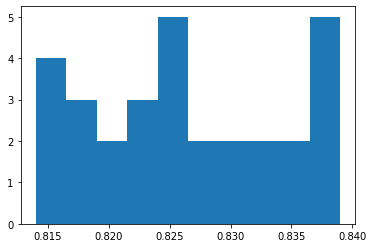

In [507]:
plt.hist(te_accuracies)
plt.show()